# Deep Learining approach
The aim remains the same as before but we compute cosine similarity differently.We create a custom dataset class to generate triplets (anchor, positive, and negative samples) for training a neural network model. The model learns to project the combined features into an embedding space using fully connected layers. The training process involves optimizing a triplet margin loss to distinguish between similar and dissimilar wines. The embeddings are then extracted and used to compute cosine similarity between wines

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset

In [124]:

wines = pd.read_csv("XWines_Slim_1K_wines.csv", low_memory=False, encoding="utf-8", memory_map=True)
wines.head()

,WineID,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,Country,RegionID,RegionName,WineryID,WineryName,Website,Vintages
0,100001,Espumante Moscatel,Sparkling,Varietal/100%,['Muscat/Moscato'],"['Pork', 'Rich Fish', 'Shellfish']",7.5,Medium-bodied,High,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2020, 2019, 2018, 2017, 2016, 2015, 2014, 201..."
1,100002,Ancellotta,Red,Varietal/100%,['Ancellotta'],"['Beef', 'Barbecue', 'Codfish', 'Pasta', 'Pizz...",12.0,Medium-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2016, 2015, 2014, 2013, 2012, 2011, 2010, 200..."
2,100003,Cabernet Sauvignon,Red,Varietal/100%,['Cabernet Sauvignon'],"['Beef', 'Lamb', 'Poultry']",12.0,Full-bodied,High,BR,Brazil,1001,Serra Gaúcha,10002,Castellamare,https://www.emporiocastellamare.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."
3,100005,Maison de Ville Cabernet-Merlot,Red,Assemblage/Bordeaux Red Blend,"['Cabernet Sauvignon', 'Merlot']","['Beef', 'Lamb', 'Game Meat', 'Poultry']",11.0,Full-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10000,Aurora,http://www.vinicolaaurora.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."
4,100007,Do Lugar Moscatel Espumantes,Sparkling,Varietal/100%,['Muscat/Moscato Bianco'],"['Pork', 'Rich Fish', 'Shellfish']",7.5,Medium-bodied,High,BR,Brazil,1001,Serra Gaúcha,10012,Dal Pizzol,http://www.dalpizzol.com.br,"[2018, 2017, 2016, 2015, 2014, 2013, 2012, 201..."


In [125]:
# Map wine_id to indices
wine_ids = wines['WineID'].unique()
wine_to_index = {id: index for index, id in enumerate(wine_ids)}
index_to_wine = {index: id for index, id in enumerate(wine_ids)}

# Define features that will be embedded in the NN

In [126]:
# Define continuous and categorical feature names
continuous_features_names = ["ABV"]
categorical_features_names = ["Type","Body","Acidity"]  # Add more categorical features as needed

# Extract continuous features
continuous_features = wines[continuous_features_names]

# Normalize continuous features
continuous_features = (continuous_features - continuous_features.mean()) / continuous_features.std()

# Extract categorical features
categorical_features = wines[categorical_features_names]

# Perform one-hot encoding on categorical features
categorical_features = pd.get_dummies(categorical_features, columns=categorical_features_names)

# Combine continuous and categorical features
features = pd.concat([continuous_features, categorical_features], axis=1)

# Convert features to numpy array
wine_features = features.to_numpy()

# Update the original DataFrame with normalized continuous features and one-hot encoded categorical features
wines.drop(columns=continuous_features_names + categorical_features_names, inplace=True)
wines = pd.concat([wines, features], axis=1)

all_feature_names = np.concatenate((continuous_features.columns.values, categorical_features.columns.values))


# Create a simple dataset and dataloader
A custom dataset class is defined for triplet training, which involves selecting an anchor wine, a positive (similar) wine, and a negative (dissimilar) wine. Random selection ensures a diverse set of training samples. The DataLoader facilitates efficient batch processing and shuffling, which is essential for effective training of the model.

In [127]:
class WineTripletDataset(Dataset):
    def __init__(self, df):
        self.wine_ids = df['WineID'].values
        self.features = df[all_feature_names].astype('float64').values
        self.num_wines = len(self.wine_ids)
    
    def __len__(self):
        return self.num_wines
    
    def __getitem__(self, idx):
        anchor_features = self.features[idx]
        positive_idx = np.random.randint(0, self.num_wines)
        negative_idx = np.random.randint(0, self.num_wines)
        positive_features = self.features[positive_idx]
        negative_features = self.features[negative_idx]
        return (
            torch.tensor(anchor_features, dtype=torch.float32),
            torch.tensor(positive_features, dtype=torch.float32),
            torch.tensor(negative_features, dtype=torch.float32)
        )

triplet_dataset = WineTripletDataset(wines)
triplet_dataloader = DataLoader(triplet_dataset, batch_size=64, shuffle=True)


# Define the model
We define a simple neural network model with an embedding layer that learns a vector representation (embedding) for each wine. The embedding dimension is set to 50, which balances between capturing enough detail and computational efficiency. This model transforms wine IDs into meaningful vectors in a lower-dimensional space.

In [128]:
class WineEmbeddingModel(nn.Module):
    def __init__(self, input_dim, embedding_dim=50):
        super(WineEmbeddingModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, embedding_dim)
        self.fc2 = nn.Linear(embedding_dim, embedding_dim)
    
    def forward(self, features):
        x = F.relu(self.fc1(features))
        x = self.fc2(x)
        return x

input_dim = wine_features.shape[1]
embedding_dim = 50
model = WineEmbeddingModel(input_dim, embedding_dim)


# Loss and optimizer
The TripletMarginLoss is chosen as it encourages the model to learn embeddings where the positive wine is closer to the anchor wine than the negative wine by a margin. The Adam optimizer is used for its efficiency and adaptive learning rate capabilities, helping in faster convergence.

In [129]:
criterion = nn.TripletMarginLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model to learn embeddings
This function trains the model using the triplet loss. For each epoch, the model processes batches of triplets (anchor, positive, negative), computes the embeddings, calculates the loss, and updates the model parameters. Printing the loss per epoch helps monitor training progress and performance.

In [130]:
def train_triplet(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for anchor_features, positive_features, negative_features in dataloader:
            optimizer.zero_grad()
            anchor_embedding = model(anchor_features)
            positive_embedding = model(positive_features)
            negative_embedding = model(negative_features)
            loss = criterion(anchor_embedding, positive_embedding, negative_embedding)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}')

train_triplet(model, triplet_dataloader, criterion, optimizer, epochs=10)


Epoch 1, Loss: 1.011407308280468
Epoch 2, Loss: 1.002706728875637
Epoch 3, Loss: 0.9978330470621586
Epoch 4, Loss: 1.0087794251739979
Epoch 5, Loss: 1.0158899500966072
Epoch 6, Loss: 1.008844394236803
Epoch 7, Loss: 1.014728032052517
Epoch 8, Loss: 1.0174224227666855
Epoch 9, Loss: 0.9932498522102833
Epoch 10, Loss: 0.9997382685542107


# Extract embeddings
After training, we extract the learned embeddings from the model. These embeddings are numerical representations of wines in a lower-dimensional space, capturing similarities and differences based on the training process.

In [131]:
wine_embeddings = model.fc1.weight.data.numpy()

# Function to find similar wines
This function identifies wines similar to a given wine based on cosine similarity of their embeddings. 

In [132]:
def find_similar_wines(wine_id, wine_embeddings, num_recommendations=5):
    wine_index = wine_to_index[wine_id]
    wine_embedding = wine_embeddings[wine_index]
    
    # Compute cosine similarity
    cosine_similarities = np.dot(wine_embeddings, wine_embedding) / (np.linalg.norm(wine_embeddings, axis=1) * np.linalg.norm(wine_embedding))
    
    similar_indices = np.argsort(cosine_similarities)[::-1]
    similar_wine_ids = [index_to_wine[idx] for idx in similar_indices[:num_recommendations + 1] if idx != wine_index][:num_recommendations]
    similar_values = [cosine_similarities[idx] for idx in similar_indices[:num_recommendations + 1] if idx != wine_index][:num_recommendations]
    
    return list(zip(similar_wine_ids, similar_values))


# Example: Find similar wines to a given wine

In [138]:
#input_wine_id = wines['WineID'].iloc[0]

#input_wine_id = 100003 #french
input_wine_id = 100056 #italian

similar_wines = find_similar_wines(input_wine_id, wine_embeddings)
print(f"Top similar wines to {input_wine_id}: {similar_wines}")

Top similar wines to 100056: [(100125, 0.60709673), (101154, 0.60467243), (100046, 0.5064467), (100135, 0.4525203), (100062, 0.35423604)]


# Visualization of results

In [139]:
def visualize_similar_wines(input_wine_id, similar_wine_data):
    input_wine_name = wines[wines['WineID'] == input_wine_id]['WineName'].values[0]
    similar_wine_names = [wines[wines['WineID'] == wine_id]['WineName'].values[0] for wine_id, _ in similar_wine_data]
    similar_values = [similarity for _, similarity in similar_wine_data]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=similar_wine_names, y=similar_values, palette="viridis")
    plt.title(f"Top similar wines to {input_wine_name}")
    plt.ylabel('Similarity')
    plt.xlabel('Wine Name')
    plt.xticks(rotation=45)
    plt.show()

C:\Users\P2001\AppData\Local\Temp\ipykernel_17116\3917695745.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=similar_wine_names, y=similar_values, palette="viridis")


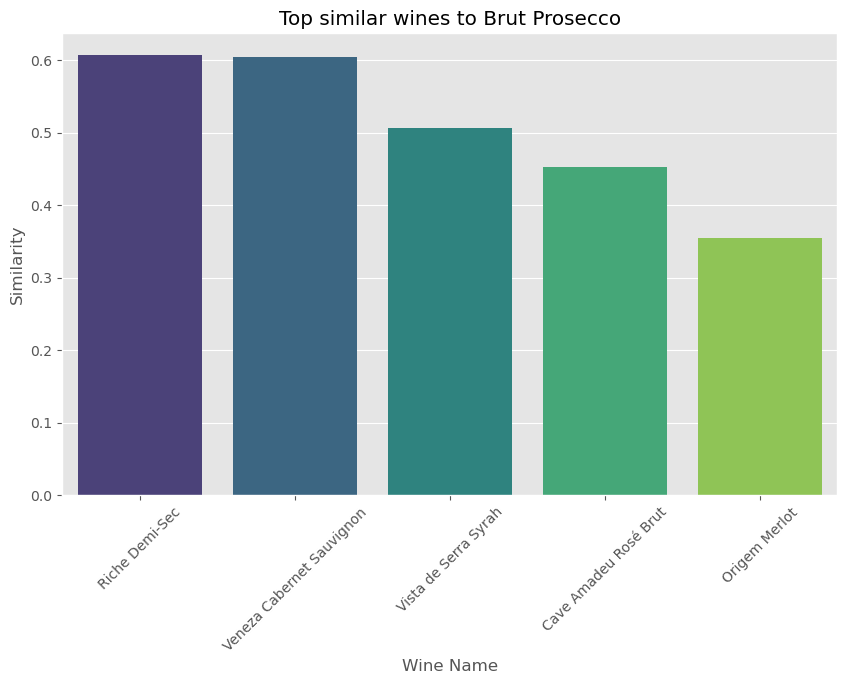

In [140]:
visualize_similar_wines(input_wine_id, similar_wines)